# FBP demo 4 - FDK cone beam reconstruction with DAPHNE

-----------------------------------------------------------------------------------------------------------------------

<u>*The material provided in this notebook can be freely used and modified for educational purposes only. Please cite any content of the notebook as follows:*</u>

- *Panetta D, Camarlinghi N. 3D Image Reconstruction for CT and PET : A Practical Guide with Python. CRC Press; 2020. Available from: https://www.taylorfrancis.com/books/9780429270239*

*For questions, notifications of bugs, or even just for feedback, please contact the authors directly (daniele.panetta@ifc.cnr.it; niccolo.camarlinghi@gmail.com)*

-----------------------------------------------------------------------------------------------------------------------

In [1]:
import sys
import numpy as np
sys.path.append("../") # this to be able to include all the object contained in the modules
from Misc.Utils import Unpickle,ReadImage,DownscaleImage
from Misc.Preview import Visualize3dImage
import matplotlib.pyplot as plt
# set the default size of all the plots 5x5 inches
plt.rcParams['figure.figsize'] = [5, 5]
from Algorithms.SinogramGenerator_3D import SinogramGenerator_3D
from Algorithms.FBP import FBP
from Geometry.ExperimentalSetupCT_3D import ExperimentalSetupCT_3D, Mode, DetectorShape
from Algorithms.MLEM import MLEM
from Misc.DataTypes import voxel_dtype


### Create a CT experimental setup

Let's now create an experimental setup as done in the previous demos, in a pretty similar way of the FBP demo 3 in fan beam geometry. In this case the value of the ```mode``` member of ```my_experimental_setup``` must be set to ```Mode.CONEBEAM```. The chosen detector shape for this example is ```DetectorShape.PLANAR```.
SDD and SAD denote the source-to-detector and source-to-axis distances, respectively. As in the fan beam example, the actual size of the detector row is a derived parameter, calculated on top of ```pixels_per_slice_nb``` and ```fan_angle_deg```. The relationship between number of voxels, voxel size and volume size is the same as in the previous examples.

In [32]:
# create CT experimental setup
my_experimental_setup = ExperimentalSetupCT_3D()
my_experimental_setup.mode = Mode.CONEBEAM
my_experimental_setup._detector_number = 3
# detector 
my_experimental_setup.pixels_per_slice_nb=150
my_experimental_setup.detector_slice_nb=150
my_experimental_setup.slice_pitch_mm=1
my_experimental_setup.detector_shape=DetectorShape.PLANAR
# number of rotation of the gantry
my_experimental_setup.gantry_angles_nb = 1
# range of the rotation
my_experimental_setup.angular_range_deg = 360
# fov size in mm 
my_experimental_setup.image_matrix_size_mm = np.array([100,100,100])
# voxel size in mm
my_experimental_setup.voxel_size_mm = np.array([1,1,1])
# sources 
my_experimental_setup.sdd_mm=350
my_experimental_setup.sad_mm=300
my_experimental_setup.fan_angle_deg=23
# compute the geometry
my_experimental_setup.Update()
print(my_experimental_setup.GetInfo())

detector_size: 142 mm    #calculated as 2*sdd*tan(fan_angle/2)
_detector_number, _detector_pixel_nb, gantry_angles_nb 3 22500 1
detector_type: DetectorType.CT
mode: Mode.CONEBEAM
pixels_per_slice_nb: 150
detector_slice_nb: 150
slice_pitch_mm: 1
detector_shape: DetectorShape.PLANAR
gantry_angles_nb: 1
angular_range_deg: 360
image_matrix_size_mm: [100 100 100]
voxel_size_mm: [1 1 1]
sdd_mm: 350
sad_mm: 300
fan_angle_deg: 23
number of projections: 67500


You may have noticed that in this example, a voxel size of 4 mm has been chosen along each axis. Indeed, in order to keep the forward and back projection within reasonable time in this single-core, non parallelised educational implementation, we will use a rather coarse reconstruction grid.

### Display the experimental setup

As already done in the previous demos, let's look at the geometry using the ```Draw``` method:

In [19]:
my_experimental_setup.Draw(use_jupyter=0,camera_pos_mm=(0,-800,400))

### Load the image used to generate cone beam projection data

Let us now load another version of the voxelised 3D Shepp-Logan phantom, provided along with the example data. This version is stored in a grid of 256$^3$ voxels (let's assume that each voxel has a side of 1 mm in each direction).

In [ ]:
input_img = np.fromfile("../Data/SheppLogan3D_100x100x100_16bit_us.raw",dtype=np.uint16).reshape ((100,100,100))
input_img=input_img.astype(voxel_dtype)
#input_img = input_img[:100:10,:100:10,:100:10]
# rearrange the image so that it is displayed properly

fig, ax = plt.subplots(1, 3, figsize=(6,12))
ax[0].imshow(input_img[50,:,:])
ax[1].imshow(input_img[:,50,:])
ax[2].imshow(input_img[:,:,50])



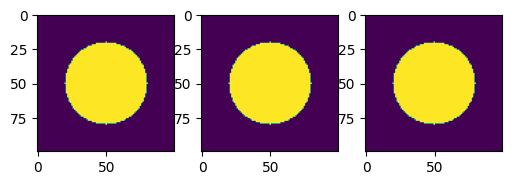

In [33]:
input_img = np.load('/home/eleonora/Dottorato/esami/corso_dottorato/snippets/sfera.npz')['matrice']
fig, ax = plt.subplots(1, 3, figsize=(6,12))
ax[0].imshow(input_img[50,:,:])
ax[1].imshow(input_img[:,50,:])
ax[2].imshow(input_img[:,:,50])

### Generate and display the projection data

Also in cone-beam geometry, the interface of DAPHNE for generating projection data does not change with respect to other geometries:

In [34]:
s=SinogramGenerator_3D(my_experimental_setup)
sino_list=s.GenerateObjectSinogram(input_img,transponse_image=1)

for s in sino_list: 
    print('sino_list[s].shape: ' , s._data.shape)

index:  0
index:  22500ta, 33% done...
index:  45000ta, 33% done...
sino_list[s].shape:  (150, 1, 150)
sino_list[s].shape:  (150, 1, 150)
sino_list[s].shape:  (150, 1, 150)


But let us now clarify the meaning of the term *sinogram* in the current geometry. We are actually generating a set of projections of the 3D object, giving rise to a 3D array of line integrals. The shape of the generated array follows the ordering: ```(n_of_radial_bins, n_of gantry_angles, n_of_bins_along_axial_direction)```. That is, the first two dimensions are those used in 2D sinograms as already seen in the previous example. But in cone-beam geometry, we often refer to projection data as *radiographs* of the 3D object, and hence we would like to visualise those data using the ordering ```(n_of_radial_bins, n_of_bins_along_axial_direction, n_of gantry_angles)```. This can be easily done with the ```Draw``` function by just putting ```slice_axis=1``` as the second argument (unlike the previous examples where ```slice_axis=2``` was used).

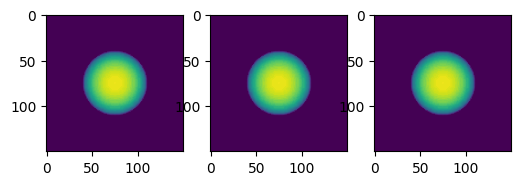

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(6,12))
ax[0].imshow(sino_list[0]._data[:,0,:])
ax[1].imshow(sino_list[1]._data[:,0,:])
ax[2].imshow(sino_list[2]._data[:,0,:])


In [36]:
projections1 = np.concatenate(np.concatenate(np.transpose(sino_list[0]._data, axes=(2,1,0)), axis=1))
projections2 = np.concatenate(np.concatenate(np.transpose(sino_list[1]._data, axes=(2,1,0)), axis=1))
projections3 = np.concatenate(np.concatenate(np.transpose(sino_list[2]._data, axes=(2,1,0)), axis=1))

projections = np.concatenate((projections1, projections2))
projections = np.concatenate((np.concatenate((projections1, projections2)), projections3))

In [ ]:
projections = np.concatenate(np.concatenate(np.transpose(sino_list[0]._data, axes=(2,1,0)), axis=1))
projections.shape

In [39]:
algorithm="MLEM"
# number of iterations 
niter=100
# when use using MLEM or OSEM remember to set this value to !=0 
initial_value=1

In [40]:
it = eval( algorithm+ "()")
it.SetExperimentalSetup(my_experimental_setup)
it.SetNumberOfIterations(niter)
#it.SetNumberOfSubsets(nsubsets)
it.SetProjectionData(projections)
# start with a initial_guess filled image
initial_guess=np.full(it.GetNumberOfVoxels(),initial_value, dtype=voxel_dtype) 
it.SetImageGuess(initial_guess)
# uncomment this line to save images to disk
#it.SetOutputBaseName(basename)
output_img = it.Reconstruct()

Algorithm name MLEM
iteration 1 => time: 5.8 s
iteration 2 => time: 5.5 s
iteration 3 => time: 5.6 s
iteration 4 => time: 5.4 s
iteration 5 => time: 5.3 s
iteration 6 => time: 5.6 s
iteration 7 => time: 5.4 s
iteration 8 => time: 5.4 s
iteration 9 => time: 5.4 s
iteration 10 => time: 5.4 s
iteration 11 => time: 5.4 s
iteration 12 => time: 5.4 s
iteration 13 => time: 5.4 s
iteration 14 => time: 5.5 s
iteration 15 => time: 5.5 s
iteration 16 => time: 5.4 s
iteration 17 => time: 5.4 s
iteration 18 => time: 5.4 s
iteration 19 => time: 5.4 s
iteration 20 => time: 5.4 s
iteration 21 => time: 5.4 s
iteration 22 => time: 5.4 s
iteration 23 => time: 5.4 s
iteration 24 => time: 5.4 s
iteration 25 => time: 5.3 s
iteration 26 => time: 5.3 s
iteration 27 => time: 5.6 s
iteration 28 => time: 5.5 s
iteration 29 => time: 5.5 s
iteration 30 => time: 5.6 s
iteration 31 => time: 5.5 s
iteration 32 => time: 5.6 s
iteration 33 => time: 5.7 s
iteration 34 => time: 5.6 s
iteration 35 => time: 5.5 s
iteration

(100, 100, 100)


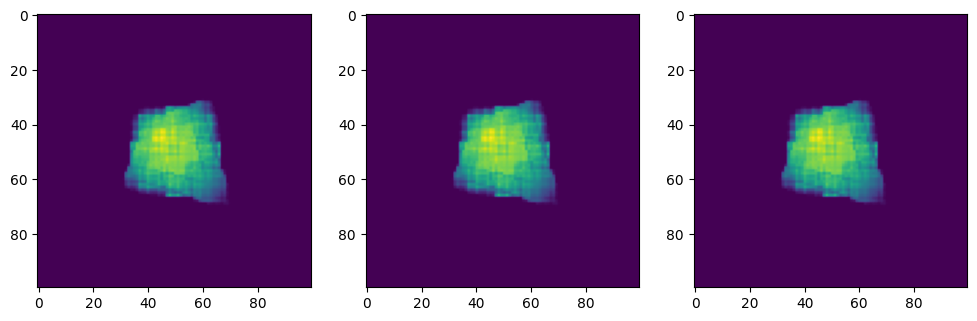

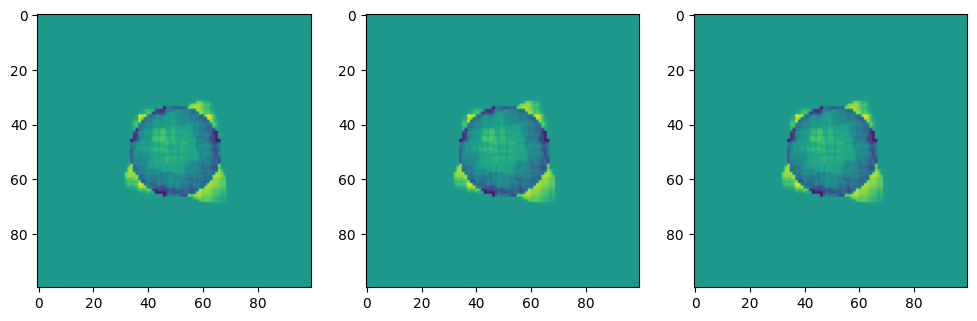

In [56]:
print(output_img.shape)
index_x = 25
index_y = 25
index_z = 25

fig, ax = plt.subplots(1, 3, figsize=(12,12))
ax[0].imshow(output_img[index_x,:,:])
ax[1].imshow(output_img[:,index_y,:])
ax[2].imshow(output_img[:,:,index_z])


fig, ax = plt.subplots(1, 3, figsize=(12,12))
ax[0].imshow(output_img[index_x,:,:]-input_img[index_x, :, : ])
ax[1].imshow(output_img[:,index_y,:] - input_img[:, index_y,:])
ax[2].imshow(output_img[:,:,index_z] - input_img[:,:,index_z])